# Artistic style transfer with CNNs

__Neural style transfer__ is the process of applying the "style" of a reference image to a specific target image such that in the process, the original "content" of the target image remains unchanged.

# Import some necessary dependencies

In [0]:
from PIL import Image
import io

import matplotlib.pyplot as plt
params = {
    'legend.fontsize': 'x-large',
    'figure.figsize': (15, 5),
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
plt.rcParams.update(params)

# Some constants

In [0]:
# This is the name of the image we want to transform.
TARGET_IMG = 'city_road.jpg'
# This is the name of the style image.
REFERENCE_STYLE_IMG = 'style2.png'

# Upload the files

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving city_road.jpg to city_road (1).jpg
Saving style2.png to style2 (1).png
User uploaded file "city_road.jpg" with length 74429 bytes
User uploaded file "style2.png" with length 608878 bytes


## Visualize uploaded images

Text(0.5,1,'Style image')

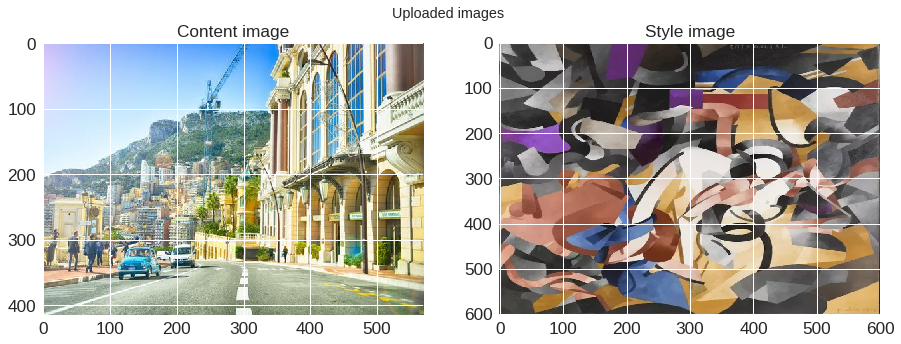

In [4]:
fig, axes = plt.subplots(1, 2)

fig.suptitle('Uploaded images')

axes[0].imshow(
    Image.open(fp=io.BytesIO(uploaded[TARGET_IMG])).convert('RGB'),
    aspect='auto')
axes[0].set_title('Content image')

axes[1].imshow(
    Image.open(fp=io.BytesIO(uploaded[REFERENCE_STYLE_IMG])).convert('RGB'),
    aspect='auto')
axes[1].set_title('Style image')

# Image Processing utilities

In [5]:
import numpy as np
from keras.applications import vgg19
from keras.preprocessing.image import img_to_array


# Preprocesses an image
def preprocess_image(img_name, uploaded_files, height=None, width=None):
    uploaded_img = Image.open(fp=io.BytesIO(uploaded[img_name])).convert('RGB')

    uploaded_width, uploaded_height = uploaded_img.size
    height = 320 if height is None else height
    width = int(
        uploaded_width * height / uploaded_height) if width is None else width

    # resize the image
    uploaded_img = uploaded_img.resize((width, height))

    # convert image to numpy array
    uploaded_img = img_to_array(uploaded_img)
    uploaded_img = np.expand_dims(uploaded_img, axis=0)
    uploaded_img = vgg19.preprocess_input(uploaded_img)
    return uploaded_img


# Deprocesses an image
def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Using TensorFlow backend.


# Setup symbolic placeholders for images

In [0]:
from keras import backend as K

target_image = K.constant(preprocess_image(TARGET_IMG, uploaded))
img_height, img_width = target_image.shape.as_list()[
    1], target_image.shape.as_list()[2]

style_image = K.constant(
    preprocess_image(
        REFERENCE_STYLE_IMG, uploaded, height=img_height, width=img_width))

# Placeholder for our generated image
generated_image = K.placeholder((1, img_height, img_width, 3))

# Combine the 3 images into a single batch
input_tensor = K.concatenate(
    [target_image, style_image, generated_image], axis=0)

In [7]:
target_image.shape

TensorShape([Dimension(1), Dimension(320), Dimension(439), Dimension(3)])

In [8]:
style_image.shape

TensorShape([Dimension(1), Dimension(320), Dimension(439), Dimension(3)])

In [9]:
input_tensor.get_shape()

TensorShape([Dimension(3), Dimension(320), Dimension(439), Dimension(3)])

# Setup the VGG-19 CNN model

In [0]:
# We will build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights and no fully connected layers.
model = vgg19.VGG19(
    input_tensor=input_tensor, weights='imagenet', include_top=False)

In [11]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 320, 439, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 320, 439, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 160, 219, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 160, 219, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 160, 219, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 80, 109, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 80, 109, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 80, 109, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 80, 109, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 80, 109, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 40, 54, 256) dtype=float32>,
 'bloc

# Define the content loss

This assuming we usually get feature representations relevant to the "content" of images from the top layers of a CNN, the generated image is expected to look similar to the base target image.

In [0]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# Define the style loss

In [0]:
def style_loss(style, combination, height, width):
    def build_gram_matrix(x):
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
        gram_matrix = K.dot(features, K.transpose(features))
        return gram_matrix

    S = build_gram_matrix(style)
    C = build_gram_matrix(combination)
    channels = 3
    size = height * width
    return K.sum(K.square(S - C)) / (4. * (channels**2) * (size**2))

# Define the total variation loss

In [0]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(x[:, :img_height - 1, :img_width - 1, :] -
                 x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

# Building the loss function

In [15]:
# weights for the weighted average loss function
content_weight = 0.025
style_weight = 1.0
total_variation_weight = 1e-4

## set the content and style layers based on VGG architecture


# define function to set layers based on source paper followed
def set_cnn_layers(source='gatys'):
    if source == 'gatys':
        # config from Gatys et al.
        content_layer = 'block5_conv2'
        style_layers = [
            'block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1',
            'block5_conv1'
        ]
    elif source == 'johnson':
        # config from Johnson et al.
        content_layer = 'block2_conv2'
        style_layers = [
            'block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3',
            'block5_conv3'
        ]
    else:
        # use Gatys config as the default anyway
        content_layer = 'block5_conv2'
        style_layers = [
            'block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1',
            'block5_conv1'
        ]
    return content_layer, style_layers


# set the source research paper followed and set the content and style layers
source_paper = 'gatys'
content_layer, style_layers = set_cnn_layers(source=source_paper)

## build the weighted loss function

# initialize total loss
loss = K.variable(0.)

# add content loss
layer_features = layers[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)

# add style loss
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(
        style_reference_features,
        combination_features,
        height=img_height,
        width=img_width)
    loss += (style_weight / len(style_layers)) * sl

# add total variation loss
loss += total_variation_weight * total_variation_loss(generated_image)

# Build the optimizer

In [0]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, generated_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([generated_image], [loss, grads])


class Evaluator:
    def __init__(self, height=None, width=None):
        self.loss_value = None
        self.grads_values = None
        self.height = height
        self.width = width

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, self.height, self.width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values


evaluator = Evaluator(height=img_height, width=img_width)

# Run the optimizer

### This will run much faster on a GPU instance 

In [17]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'style_transfer_result_' + TARGET_IMG.split('.')[0]
result_prefix = result_prefix + '_' + source_paper
iterations = 20

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(TARGET_IMG, uploaded, height=img_height, width=img_width)
x = x.flatten()

results = {}
for i in range(iterations):
    print('Start of iteration', (i + 1))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(
        evaluator.loss, x, fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    if (i + 1) % 5 == 0 or i == 0:
        # Save current generated image only every 5 iterations
        img = x.copy().reshape((img_height, img_width, 3))
        img = deprocess_image(img)
        fname = result_prefix + '_at_iteration_%d.png' % (i + 1)
        results[fname] = img
        print('Image saved as', fname)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i + 1, end_time - start_time))

Start of iteration 1
Current loss value: 2508438000.0
Image saved as style_transfer_result_city_road_gatys_at_iteration_1.png
Iteration 1 completed in 13s
Start of iteration 2
Current loss value: 993068100.0
Iteration 2 completed in 10s
Start of iteration 3
Current loss value: 648082370.0
Iteration 3 completed in 10s
Start of iteration 4
Current loss value: 507850200.0
Iteration 4 completed in 10s
Start of iteration 5
Current loss value: 416806660.0
Image saved as style_transfer_result_city_road_gatys_at_iteration_5.png
Iteration 5 completed in 10s
Start of iteration 6
Current loss value: 362232030.0
Iteration 6 completed in 11s
Start of iteration 7
Current loss value: 319766980.0
Iteration 7 completed in 11s
Start of iteration 8
Current loss value: 289601300.0
Iteration 8 completed in 11s
Start of iteration 9
Current loss value: 264208240.0
Iteration 9 completed in 10s
Start of iteration 10
Current loss value: 244035140.0
Image saved as style_transfer_result_city_road_gatys_at_iterati

# View the results

Text(0.5,1,'Iteration 20')

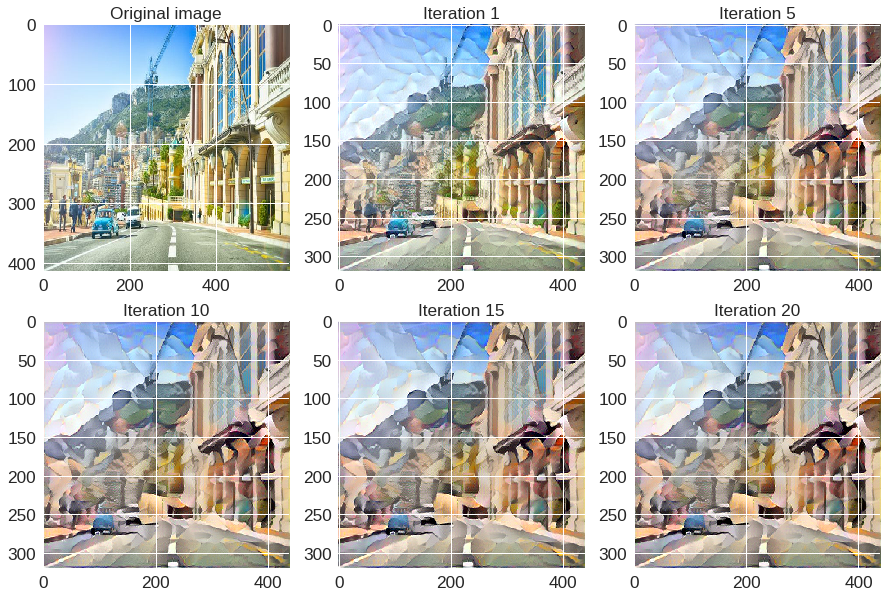

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0][0].imshow(
    Image.open(fp=io.BytesIO(uploaded['city_road.jpg'])).convert('RGB'),
    aspect='auto')
axes[0][0].set_title('Original image')

axes[0][1].imshow(
    results['style_transfer_result_city_road_gatys_at_iteration_1.png'],
    aspect='auto')
axes[0][1].set_title('Iteration 1')

axes[0][2].imshow(
    results['style_transfer_result_city_road_gatys_at_iteration_5.png'],
    aspect='auto')
axes[0][2].set_title('Iteration 5')

axes[1][0].imshow(
    results['style_transfer_result_city_road_gatys_at_iteration_10.png'],
    aspect='auto')
axes[1][0].set_title('Iteration 10')

axes[1][1].imshow(
    results['style_transfer_result_city_road_gatys_at_iteration_15.png'],
    aspect='auto')
axes[1][1].set_title('Iteration 15')

axes[1][2].imshow(
    results['style_transfer_result_city_road_gatys_at_iteration_20.png'],
    aspect='auto')
axes[1][2].set_title('Iteration 20')